In [2]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from basic_functions import *
from cmb import *
from flat_map import *

# Read one of the galaxy catalog

In [9]:
pathInDir = "/global/cscratch1/sd/eschaan/SehgalRadioPolarizedSources/input/sehgal_ir_galaxies/"

# Choose input file
sourceCatalog = "IRBlastPop"
pathIn = pathInDir + sourceCatalog + ".dat"

# read file
data = np.genfromtxt(pathIn)#, max_rows=nObjMax)
IObj = data[:,0]
ra = data[:,1]
dec = data[:,2]
z = data[:,3]
# f30_mJy = data[:,4]
# f90_mJy = data[:,5]
f148_mJy = data[:,6]
# f219_mJy = data[:,7]
# f277_mJy = data[:,8]
# f350_mJy = data[:,9]

print len(ra), "sources"

298 sources


## Check the location of the sources

It is known that the Sehgal sims only have one octant. Weirdly, they are not always exactly confined in the octant: some objects are slightly outside:

In [11]:
print "coordinates should be between 0 and 90"
print np.min(ra), np.max(ra)
print np.min(dec), np.max(dec)

coordinates should be between 0 and 90
0.0522388 89.3023376
0.3434377 85.250351


For an isotropic distribution of sources,
the RA distribution should be flat
and the dec distribution should go as $\cos(\text{dec})$

/global/homes/e/eschaan/.conda/envs/namaster2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


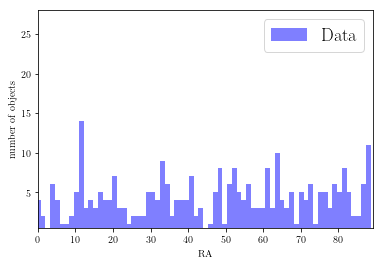

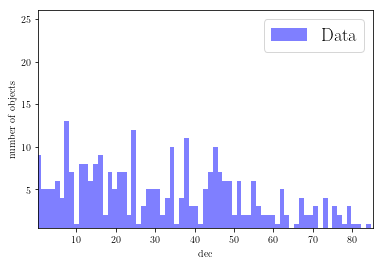

In [12]:
myHistogram(ra, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'RA', semilogx=False, semilogy=False, doGauss=False)
myHistogram(dec, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'dec', semilogx=False, semilogy=False, doGauss=False)

Throw out the objects outside of the quadrant

In [13]:
I = np.where((ra>=0.)*(ra<=90.)*(dec>=0.)*(dec<=90.))[0]
print "keeping", len(I), "objects out of", len(ra)
print "ie a fraction", 1.*len(I)/len(ra)

keeping 298 objects out of 298
ie a fraction 1.0


In [14]:
ra = ra[I]
dec = dec[I]
z = z[I]
f148_mJy = f148_mJy[I]

## Check dn/dz of sources

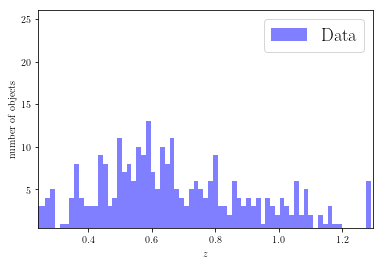

In [15]:
myHistogram(z, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$z$', semilogx=False, semilogy=False, doGauss=False)


## Check flux distribution

The flux cut when masking will be around 5mJy.

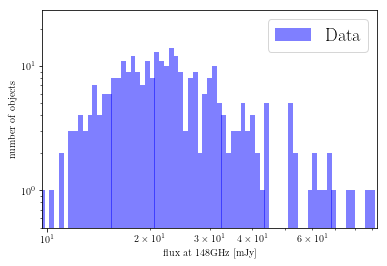

In [16]:
myHistogram(f148_mJy, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'flux at 148GHz [mJy]', semilogx=True, semilogy=True, doGauss=False)


# Generate source count map (test)

In [17]:
# Map geometry to match the Sehgal maps
nSide = 4096 #512#4096
nPix = hp.nside2npix(nSide)

# get pixel indices for all galaxies
IPix = hp.ang2pix(nSide, np.pi/2. - dec*np.pi/180., ra*np.pi/180., lonlat=False)

# print np.min(IPix), np.max(IPix)
# print nPix
# print IPix

The histogram of pixel indices should be flat, since the pixels have equal area and the sources are unclustered.

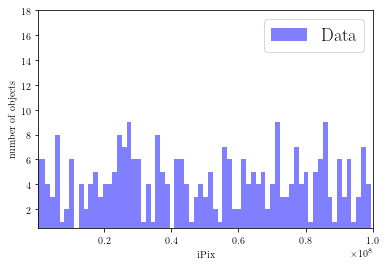

In [18]:
myHistogram(IPix, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'iPix', semilogx=False, semilogy=False, doGauss=False)


In [19]:
# Generate count map
bins = np.arange(nPix+1)-0.5
countMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy, statistic='count', bins=bins)

# IPix = 2*np.ones(nPix)
# countMap, binEdges = np.histogram(IPix, bins=nPix, range=(-0.5,nPix-0.5))

In [20]:
# print "bin edges", binEdges

print "check I have all objects", np.sum(countMap), len(ra)
print "check mean number per pixel", np.mean(countMap), 1. * len(ra) / nPix

print "check min / max number of objects per pixel", np.min(countMap), np.max(countMap)


check I have all objects 298.0 298
check mean number per pixel 1.4801820119222005e-06 1.48018201192e-06
check min / max number of objects per pixel 0.0 2.0


The pixel histogram should be a Poisson distribution

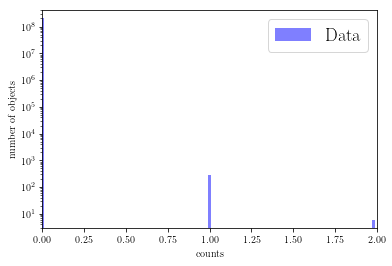

In [21]:
myHistogram(1.e-10+countMap, nBins=101, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'counts', semilogx=False, semilogy=True, doGauss=False)



Check that the correct quadrant in the sky is filled: $\text{RA}, \text{dec}\in[0, \pi/2]$.

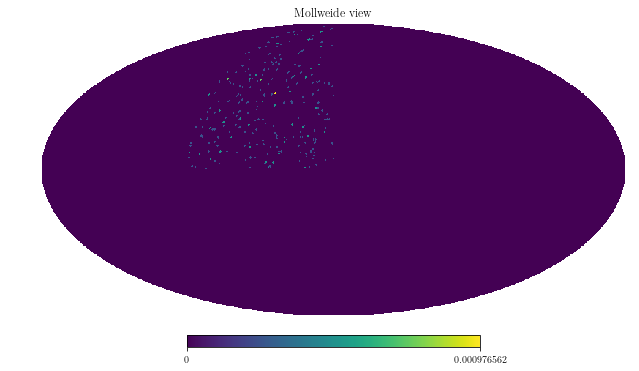

In [28]:
testMap = hp.ud_grade(countMap, 64)
hp.mollview(testMap)

# Generate T, Q, U maps

In [29]:
# Generate T map
bins = np.arange(nPix+1)-0.5
tMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy, statistic='sum', bins=bins)  # flux map [mJy]

print "check that the map contains the flux from all the sources", np.sum(tMap), np.sum(f148_mJy)
print "ratio is", np.sum(tMap) / np.sum(f148_mJy)

tMap /= hp.nside2pixarea(nSide)  # surf bright map [mJy/sr]

check that the map contains the flux from all the sources 7659.042392500001 7659.0423925
ratio is 1.0000000000000002


In [30]:
# polarization fraction: 3% from Trombetti+18 (to be improved)
alpha = 0.03
# polarization angles:
theta = np.random.uniform(low=0., high=np.pi, size=len(ra))

# Generate Q and U maps
qMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy * alpha * np.cos(2.*theta), statistic='sum', bins=bins)  # flux map [mJy]
qMap /= hp.nside2pixarea(nSide)  # surf bright map [mJy/sr]

uMap, binEdges, binIndices = stats.binned_statistic(IPix, f148_mJy * alpha * np.sin(2.*theta), statistic='sum', bins=bins)  # flux map [mJy]
uMap /= hp.nside2pixarea(nSide)  # surf bright map [mJy/sr]

## Convert all maps from [mJy/sr] to [muKcmb]

In [31]:
cmb = CMB(beam=1., noise=1., nu1=148.e9, nu2=148.e9, lMin=30., lMaxT=3.e3, lMaxP=5.e3, fg=True, atm=False, name=None)

sehgalTMap *= 1.e-3 * 1.e-26  # convert from [mJy/sr] to surf bright per unit freq = [W/m^2/Hz/sr]
sehgalTMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
sehgalTMap *= 1.e6  # convert from Kcmb to muKcmb

tMap *= 1.e-3 * 1.e-26  # convert from [mJy/sr] to surf bright per unit freq = [W/m^2/Hz/sr]
tMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
tMap *= 1.e6  # convert from Kcmb to muKcmb

qMap *= 1.e-3 * 1.e-26  # convert from [mJy/sr] to surf bright per unit freq = [W/m^2/Hz/sr]
qMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
qMap *= 1.e6  # convert from Kcmb to muKcmb

uMap *= 1.e-3 * 1.e-26  # convert from [mJy/sr] to surf bright per unit freq = [W/m^2/Hz/sr]
uMap /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from surf bright per unit freq = [W/m^2/sr/Hz] to Kcmb
uMap *= 1.e6  # convert from Kcmb to muKcmb


# The Lambda website says:
# dT = [Jy/sr] * T_CMB / 1.072480e9 in [T_CMB units]
# Check that it works:
print "My conversion agrees with the Lambda website recommendation:", 1.e-26 / cmb.dBdT(148.e9, cmb.Tcmb), cmb.Tcmb / 1.072480e9

NameError: name 'sehgalTMap' is not defined

In [ ]:
myHistogram(1.e-4+tMap, nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$T$ [$\mu$K$_\text{CMB}$]', semilogx=True, semilogy=True, doGauss=False)
myHistogram(1.e-11+np.abs(qMap), nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$|Q|$ [$\mu$K$_\text{CMB}$]', semilogx=True, semilogy=True, doGauss=False)
myHistogram(1.e-11+np.abs(uMap), nBins=71, lim=None, S2Theory=[], path=None, plot=True, nameLatex=r'$|U|$ [$\mu$K$_\text{CMB}$]', semilogx=True, semilogy=True, doGauss=False)


/global/u1/e/eschaan/.conda/envs/namaster2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/e/eschaan/.conda/envs/namaster2.7/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


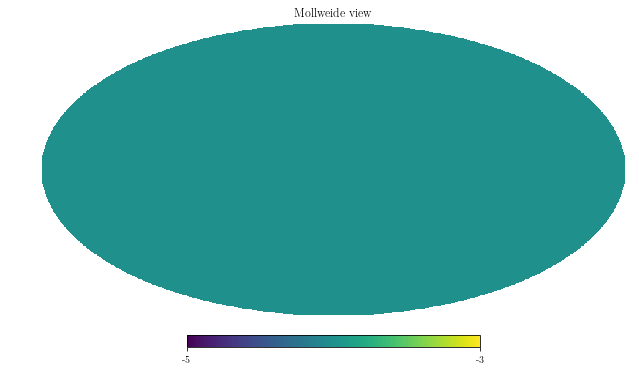

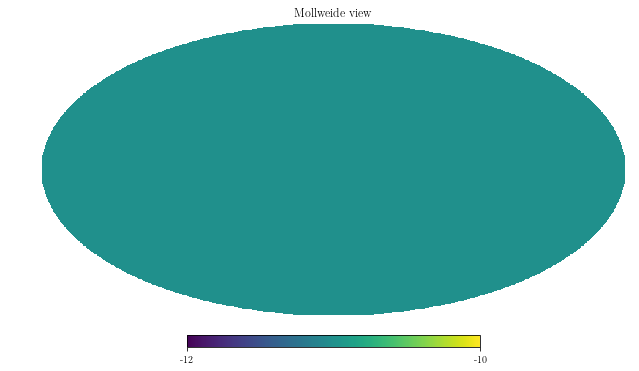

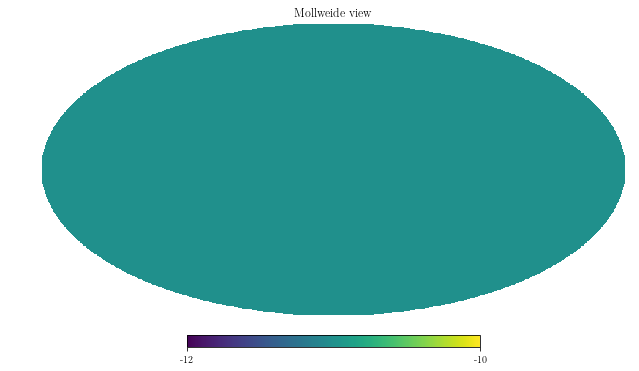

In [32]:
hp.mollview(np.log10(1.e-4+tMap))
hp.mollview(np.log10(1.e-11+qMap))
hp.mollview(np.log10(1.e-11+uMap))

## Read the kappa map

In [33]:
# kappaMap = hp.read_map("./input/sehgal_maps/healpix_4096_KappaeffLSStoCMBfullsky.fits")
# kappaMap = hp.ud_grade(kappaMap, nSide)

# Extract cutouts T, Q, U, official Sehgal T (test) and kappa

In [34]:
# position (lon, lat, psi) of the cutout center
lon = 45. # [deg]
lat = 45. # [deg]
pos = np.array([lon, lat, 0.]) 

# map side in lon and lat
dLon = 10.# [deg]
dLat = 10.# [deg]
lonRange = np.array([-dLon/2., dLon/2.]) # [deg]
latRange = np.array([-dLat/2., dLat/2.]) # [deg]
pixRes = 0.5/60.  #0.5 / 60.  # [arcmin] to [deg]

# number of pixels on the side
xSize = np.int(np.ceil(dLon / pixRes))
ySize = np.int(np.ceil(dLat / pixRes))

baseMap = FlatMap(nX=xSize, nY=ySize, sizeX=dLon*np.pi/180., sizeY=dLat*np.pi/180.)

print xSize, "pixel on the side,", dLon, "degrees on the side"
print "resolution is", dLon/xSize*60., "arcmin"

1200 pixel on the side, 10.0 degrees on the side
resolution is 0.5 arcmin


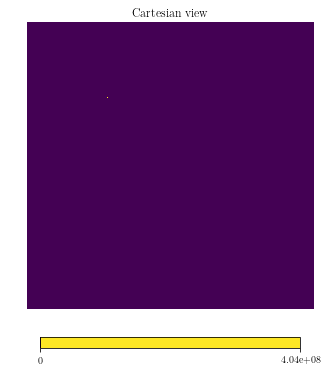

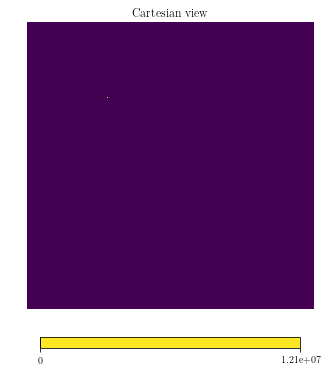

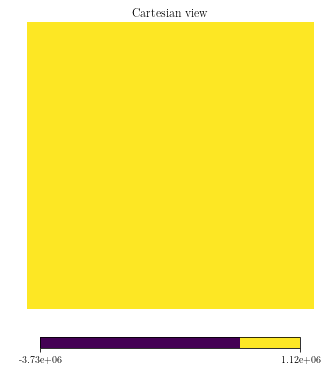

In [36]:
# Official T map
# cutTMap = hp.visufunc.cartview(tMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
# cutSehgalTMap = hp.visufunc.cartview(sehgalTMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
# T map
cutTMap = hp.visufunc.cartview(tMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
# Q map
cutQMap = hp.visufunc.cartview(qMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
# U map
cutUMap = hp.visufunc.cartview(uMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
# kappa map
# cutKappaMap = hp.visufunc.cartview(kappaMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')

## Test: mask the point sources above 15mJy, and compare power to Dunkley+13

In [37]:
# use the flux cut from Dunkley+13, to match power spectra
fluxCut = 0.015  # in [Jy]

# convert to muKcmb
fluxCut *= 1.e-26  # convert from [Jy] to flux per unit freq = [W/m^2/Hz]
fluxCut /= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from flux per unit freq = [W/m^2/Hz] to [Kcmb*sr]
fluxCut *= 1.e6  # convert from [Kcmb*sr] to [muKcmb*sr]

In [39]:
cutTMapFourier = baseMap.fourier(cutTMap)

maskPatchRadius = 3. * np.pi/(180.*60.)   # [arcmin] to [rad]
psMask = baseMap.pointSourceMaskMatchedFilterIsotropic(cmb.ftotalTT, fluxCut, fprof=None, dataFourier=cutTMapFourier, maskPatchRadius=maskPatchRadius, test=False)

basic_functions.py:228: RuntimeWarning: divide by zero encountered in double_scalars
  try: return x/y
cmb.py:163: RuntimeWarning: invalid value encountered in double_scalars
  result = a_CIBP * (l/3000.)**2 * self.fdl_to_cl(l)
cmb.py:175: RuntimeWarning: invalid value encountered in double_scalars
  result = a_CIBC * (l/3000.)**(2-n) * self.fdl_to_cl(l)
cmb.py:191: RuntimeWarning: invalid value encountered in double_scalars
  result = a_s * (l/3000.)**2* self.fdl_to_cl(l)


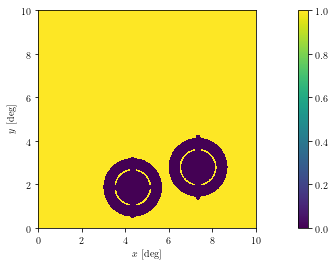

In [50]:
baseMap.plot(psMask)

Power spectrum before masking: much higher than Dunkley+13

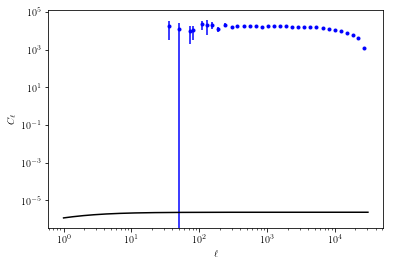

In [51]:
lCen, Cl, sCl = baseMap.powerSpectrum(cutTMapFourier, theory=[cmb.fradioPoisson], plot=True)

Power spectrum after masking: close enough to Dunkley+13.
Or zero if all the point sources have been masked

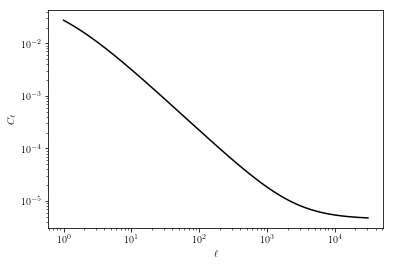

In [54]:
maskedTMapFourier = baseMap.fourier(cutTMap*psMask)
lCen, Cl, sCl = baseMap.powerSpectrum(maskedTMapFourier, theory=[cmb.fCIB], plot=True)

# Use point source mask relevant for CMB S4

In [55]:
# experimental specs for CMB S4
cmb = CMB(beam=1., noise=1., nu1=148.e9, nu2=148.e9, lMin=30., lMaxT=1.e5, lMaxP=1.e5, fg=True, atm=False, name=None)

# find the 5 sigma point source detection threshold [muK*sr]
fluxCut = 5. * cmb.fsigmaMatchedFilter(fprofile=None, ftotalTT=cmb.ftotalTT, lMin=30., lMax=1.e4)

print "the 5 sigma flux cut is", fluxCut, "muK*sr"

the 5 sigma flux cut is 5.5604680018442376e-06 muK*sr


Round it off to get a 2mJy point source cut

In [56]:
# rounded off flux cut to get 2mJy
fluxCut = 5.1e-6
# convert to mJy to check
fluxCutmJy = fluxCut * 1.e-6  # convert from [muKcmb*sr] to [Kcmb*sr]
fluxCutmJy *= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from [Kcmb*sr] to flux per unit freq = [W/m^2/Hz]
fluxCutmJy /= 1.e-26  # convert from flux per unit freq = [W/m^2/Hz] to [Jy]
fluxCutmJy *= 1.e3  # convert from [Jy] to [mJy]
print "ie", fluxCutmJy, "mJy"

# select patch radius around point sources
maskPatchRadius = 3. * np.pi/(180.*60.)   # [arcmin] to [rad]

# generate point source mask 
psMask = baseMap.pointSourceMaskMatchedFilterIsotropic(cmb.ftotalTT, fluxCut, fprof=None, dataFourier=cutTMapFourier, maskPatchRadius=maskPatchRadius, test=False)

ie 2.000556172398003 mJy


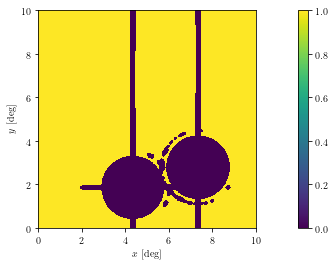

In [57]:
baseMap.plot(psMask)

# Save all cutout maps and mask

In [58]:
# np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_x_rad.txt", baseMap.x)
# np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_y_rad.txt", baseMap.y)
# np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_sehgal_T.txt", cutTMap)
# np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_sehgal_Q.txt", cutQMap)
# np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_sehgal_U.txt", cutUMap)
# np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_mask_2mJy_T.txt", psMask)

# Extract as many square cutouts as possible

In [42]:
# cutout dimensions
# map side in lon and lat
dLon = 10.# [deg]
dLat = 10.# [deg]
lonRange = np.array([-dLon/2., dLon/2.]) # [deg]
latRange = np.array([-dLat/2., dLat/2.]) # [deg]
pixRes = 0.5/60.  #0.5 / 60.  # [arcmin] to [deg]
# number of pixels on the side
xSize = np.int(np.ceil(dLon / pixRes))
ySize = np.int(np.ceil(dLat / pixRes))

baseMap = FlatMap(nX=xSize, nY=ySize, sizeX=dLon*np.pi/180., sizeY=dLat*np.pi/180.)

# create an empty map, to check footprints
nSide = 256
hMap = np.zeros(hp.nside2npix(nSide))


# offsets in lon and lat to start the cutouts
latStart = 0. #1.
lonStart = 0. #1.
# space between cutouts, to avoid overlap
space = 0.5 # [deg]

In [ ]:
# latitudes of centers of cutouts
nPatches = 0
LatCenter = np.arange(latStart + dLat/2., 90., dLat + space)
for latCenter in LatCenter:
   latUpper = latCenter + dLat/2.
   latLower = latCenter - dLat/2.
   
   dLonCenter = dLon / np.cos(latCenter * np.pi/180.)
   dLonUpper = dLon / np.cos(latUpper * np.pi/180.)
   dLonLower = dLon / np.cos(latLower * np.pi/180.)
   LonCenter = np.arange(lonStart + dLonUpper/2., 90., dLonUpper + space)
   
   for lonCenter in LonCenter:
      
      # polygon edges
      latEdges = np.array([latUpper, latLower, latLower, latUpper])
      lonEdges = np.array([lonCenter-dLonUpper/2., lonCenter-dLonLower/2., lonCenter+dLonLower/2., lonCenter+dLonUpper/2.])
      
      # check that the cutout is entirely within the quadrant
      patchFits = np.sum(latEdges<0.) + np.sum(latEdges>90.) + np.sum(lonEdges<0.) + np.sum(lonEdges>90.)
      patchFits = patchFits==0.
      
      # if it fits
      if patchFits:
         nPatches += 1
         # plot the footprint
         xyz = hp.ang2vec(lonEdges, latEdges, lonlat=True)
         I = hp.query_polygon(nSide, xyz)
         hMap[I] += 1.
         
         # extract the cutouts
         pos = np.array([lonCenter, latCenter, 0.])
         # Official T map
#          cutSehgalTMap = hp.visufunc.cartview(sehgalTMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
#          plt.clf()
         # T map
         cutTMap = hp.visufunc.cartview(tMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
         plt.clf()
         # Q map
         cutQMap = hp.visufunc.cartview(qMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
         plt.clf()
         # U map
         cutUMap = hp.visufunc.cartview(uMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
         plt.clf()
         # kappa map
#          cutKappaMap = hp.visufunc.cartview(kappaMap, rot=pos, lonra=lonRange, latra=latRange, xsize=xSize, ysize=ySize, return_projected_map=True, norm='hist')
#          plt.clf()

         # generate point source mask
#          fluxCut = 5.1e-6  # for 2mJy
         fluxCut = 12.75e-6  # for 5mJy
         # convert to mJy to check
         fluxCutmJy = fluxCut * 1.e-6  # convert from [muKcmb*sr] to [Kcmb*sr]
         fluxCutmJy *= cmb.dBdT(148.e9, cmb.Tcmb)  # convert from [Kcmb*sr] to flux per unit freq = [W/m^2/Hz]
         fluxCutmJy /= 1.e-26  # convert from flux per unit freq = [W/m^2/Hz] to [Jy]
         fluxCutmJy *= 1.e3  # convert from [Jy] to [mJy]
         print "ie", fluxCutmJy, "mJy"
         #
         # select patch radius around point sources
         maskPatchRadius = 3. * np.pi/(180.*60.)   # [arcmin] to [rad]
         #
         # generate point source mask 
         cutTMapFourier = baseMap.fourier(cutTMap)
         psMask = baseMap.pointSourceMaskMatchedFilterIsotropic(cmb.ftotalTT, fluxCut, fprof=None, dataFourier=cutTMapFourier, maskPatchRadius=maskPatchRadius, test=False)    
            
         # save the cutouts
#          np.savetxt("./output/sehgal_maps/cutouts/ps_official_sehgal_T_patch"+str(nPatches)+".txt", cutSehgalTMap)
         np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_sehgal_T_patch"+str(nPatches)+".txt", cutTMap)
         np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_sehgal_Q_patch"+str(nPatches)+".txt", cutQMap)
         np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_sehgal_U_patch"+str(nPatches)+".txt", cutUMap)
#          np.savetxt("./output/sehgal_maps/cutouts/kappa_sehgal_patch"+str(nPatches)+".txt", cutKappaMap)
         np.savetxt("./output/sehgal_maps/cutouts/ir_"+catalogName+"_mask_"+str(np.int(round(fluxCutmJy)))+"mJy_T_patch"+str(nPatches)+".txt", psMask)
         
print "Extracted "+str(nPatches)+" cutouts"

hp.mollview(hMap)
plt.show()

ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy


/global/homes/e/eschaan/.conda/envs/namaster2.7/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
ie 5.001390430995008 mJy
